In [1]:
import pandas as pd
import seaborn as sns

In [ ]:
# Data Frame(s) source: https://www.kaggle.com/datasets/subhajeetdas/car-acceptability-classification-dataset
# note that both dataframes (.csv and .data) are identical

In [2]:
df=pd.read_csv(r"car.csv")
df.head() # ok, data looks chiefly categorical, shld be ez to split and map

,Buying_Price,Maintenance_Price,No_of_Doors,Person_Capacity,Size_of_Luggage,Safety,Car_Acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
df.info() # all non null entries, no ffill / dropping of values required

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Buying_Price       1728 non-null   object
 1   Maintenance_Price  1728 non-null   object
 2   No_of_Doors        1728 non-null   object
 3   Person_Capacity    1728 non-null   object
 4   Size_of_Luggage    1728 non-null   object
 5   Safety             1728 non-null   object
 6   Car_Acceptability  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [4]:
df['Car_Acceptability'].value_counts() # imbalanced dataframe, can replicate rows to resolve the issue (upsampling)

unacc    1210
acc       384
good       69
vgood      65
Name: Car_Acceptability, dtype: int64

In [5]:
def sample_to(df,size=1200): # default size of 1200 rows
    if len(df)>=size: # if dataframe has more rows, only taskes out 1200 of it (if equaivalent essentially takes the whole df)
        sampled_df=df.sample(size)
    elif len(df)<size: # if dataframe is smaller than size, replicates each row 'repeats' times; repeats is var below 
        repeats=round(size/len(df),0)  # rounded number of replications by dividing size by actual number of rows in df and rounding it
        sampled_df=df.loc[df.index.repeat(repeats)]
    sampled_df=sampled_df.reset_index(drop=True)
    return sampled_df

sampled_unacc=sample_to(df[df['Car_Acceptability'].str.startswith('u')])
sampled_acc=sample_to(df[df['Car_Acceptability'].str.startswith('a')])
sampled_g=sample_to(df[df['Car_Acceptability'].str.startswith('g')])
sampled_vg=sample_to(df[df['Car_Acceptability'].str.startswith('v')])

In [6]:
new_df=pd.concat([sampled_unacc,sampled_acc,sampled_g,sampled_vg]).reset_index(drop=True)
new_df['Car_Acceptability'].value_counts() # much more balanced

unacc    1200
good     1173
vgood    1170
acc      1152
Name: Car_Acceptability, dtype: int64

In [7]:
for col in new_df.columns:
    print(col,new_df[col].unique()) # ok, not a large variety of categorical variables for all columns, can be mapped easily

Buying_Price ['med' 'low' 'vhigh' 'high']
Maintenance_Price ['high' 'med' 'vhigh' 'low']
No_of_Doors ['5more' '4' '2' '3']
Person_Capacity ['more' '2' '4']
Size_of_Luggage ['med' 'small' 'big']
Safety ['low' 'med' 'high']
Car_Acceptability ['unacc' 'acc' 'good' 'vgood']


In [8]:
pri_map={'low':0,'med':1,'high':2,'vhigh':3} # can automate this by using LabelEncoder / creating a function that maps unique values to 
# ever increasing numbers; but I prefer this more manual approach for me to see and comprehend the mapping
saf_map={'low':0,'med':1,'high':2}
door_map={'5more':5,'3':3,'4':4,'2':2}
cap_map={'2':2,'4':4,'more':6}
luggage_map={'small':0,'med':1,'big':2}
car_map={'unacc':0,'acc':1,'good':2,'vgood':3}

map_df=new_df 
map_df['Buying_Price']=map_df['Buying_Price'].map(pri_map)
map_df['Maintenance_Price']=map_df['Maintenance_Price'].map(pri_map)
map_df['No_of_Doors']=map_df['No_of_Doors'].map(door_map)
map_df['Person_Capacity']=map_df['Person_Capacity'].map(cap_map)
map_df['Size_of_Luggage']=map_df['Size_of_Luggage'].map(luggage_map)
map_df['Safety']=map_df['Safety'].map(saf_map)
map_df['Car_Acceptability']=map_df['Car_Acceptability'].map(car_map)

In [9]:
map_df.head() # all numbers now

,Buying_Price,Maintenance_Price,No_of_Doors,Person_Capacity,Size_of_Luggage,Safety,Car_Acceptability
0,1,2,5,6,1,0,0
1,0,1,4,2,0,0,0
2,3,2,2,6,1,0,0
3,3,2,3,4,2,0,0
4,1,3,3,6,0,0,0


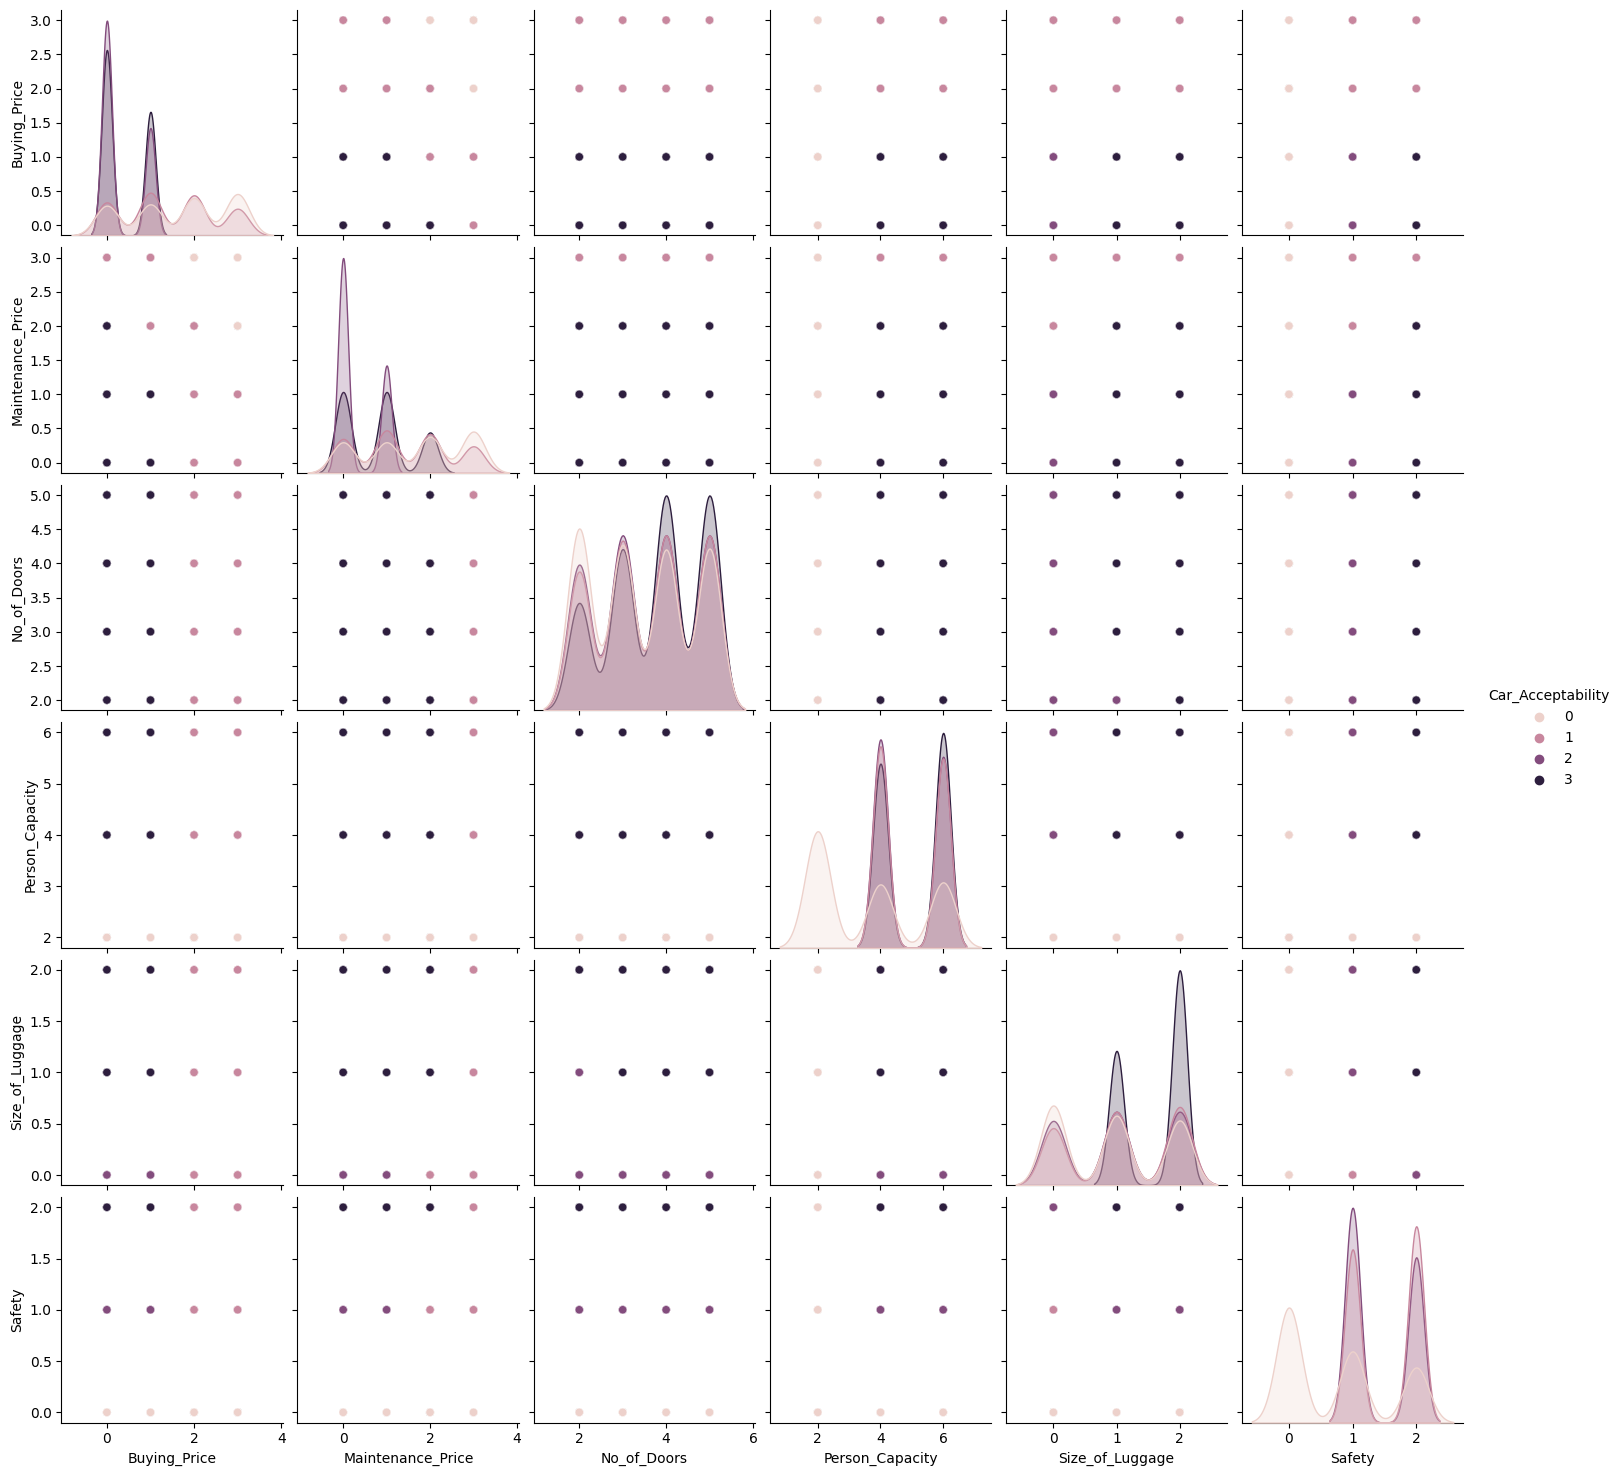

In [19]:
sns.pairplot(map_df,hue='Car_Acceptability',plot_kws={'alpha':0.4}) # pairplot to view correlation between variables

In [31]:
# buying and maintenance prices apear highly correlated on pairplots, increase in 1 decreases acceptability; increase in both guarantees
# low acceptability
# increase in number of doors makes it more likely for car to be very good
# most useful feature would be safety
# capacity and number of door will prove to be determiners 

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report


X=map_df[['Buying_Price','Safety','Size_of_Luggage','Person_Capacity','No_of_Doors','Maintenance_Price']]
y=map_df['Car_Acceptability']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

model=KNeighborsClassifier(n_neighbors=3) # interestingly prescence of all dependent variables proves to yield highest f1-scores across 
# all y-values for classifier

In [29]:
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred,target_names=list(car_map.keys()))) 

              precision    recall  f1-score   support

       unacc       1.00      0.85      0.92       240
         acc       0.88      0.96      0.92       230
        good       0.96      1.00      0.98       235
       vgood       0.97      1.00      0.99       234

    accuracy                           0.95       939
   macro avg       0.95      0.95      0.95       939
weighted avg       0.95      0.95      0.95       939



c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
